# Defect Calculation Parsing
For parsing defect calculation results with `doped`, we need the following VASP output files
from our bulk and defect supercell calculations:
- `vasprun.xml(.gz)`
- Either:
    - `OUTCAR(.gz)`, if using the Kumagai-Oba (eFNV) charge correction scheme (compatible with isotropic
     or anisotropic (non-cubic) dielectric constants; **recommended**), or
    - `LOCPOT(.gz)`, if using the Freysoldt (FNV) charge correction scheme (isotropic dielectric
    screening only).

Note that `doped` can read the compressed versions of these files (`.gz`/`.xz`/`.bz`/`.lzma`), so we can
 do e.g. `gzip OUTCAR` to reduce the file sizes when downloading and storing these files on our local
 system.

To quickly compress these output files on our HPC, we can run the following from our top-level folder
containing the defect directories (e.g. `Te_i_Te2.83_+2` etc):
```{code-block} shell
for defect_dir in */vasp_*; do cd $defect_dir; gzip vasprun.xml OUTCAR; cd ../..; done
```
(change `OUTCAR` to `LOCPOT` if using the FNV isotropic charge correction), and then download the files
to the relevant folders by running the following from our local system:
```{code-block} shell
for defect_dir in */vasp_*; do cd $defect_dir;
scp [remote_machine]:[path to doped folders]/${defect_dir}/\*gz .;
cd ../..; done
```
changing `[remote_machine]` and `[path to doped folders]` accordingly.

```{tip}
You can run this notebook interactively through [Google Colab](https://colab.research.google.com/github/SMTG-Bham/doped/blob/develop/examples/parsing_tutorial.ipynb) or [Binder](https://mybinder.org/v2/gh/SMTG-Bham/doped/develop?urlpath=tree/examples/parsing_tutorial.ipynb) – just click the links!
If running on Colab, then you'll need to run `!pip install doped` in a cell to install the package, and `!git clone https://github.com/SMTG-Bham/doped` to download the example data (and update paths in the code cells accordingly).
```

##  Example: CdTe Defect Calculations
In this example, we parse some defect calculations for CdTe. In this case, these
 defects weren't initially generated with `doped`, but this is fine, as `doped` can parse the
 results and automatically determine the defect type and site from the relaxed structure.

```{note}
If you want to use the example outputs shown in this parsing tutorial, you can do so by cloning the `doped` GitHub repository and following the ``dope_parsing_example.ipynb`` Jupyter notebook.
In this case, you will witness some extra warnings during parsing due to some mismatching tags in the bulk/defect outputs – purposely included for testing. 
```
<!--- SK comment: For generating tutorial version, temporarily comment out `if multiple:...` for OUTCAR parsing and comment out "check if same type of charge correction" warning block for multiple corrections  --->

In [1]:
from doped.analysis import DefectsParser
%matplotlib inline

In [29]:
dielectric = 9.13  # dielectric constant (this can be a single number (isotropic), or a 3x1 array or 3x3 matrix (anisotropic))
dp = DefectsParser("CdTe/v_Cd_example_data", dielectric=dielectric)  # dielectric needed for charge corrections

Parsing v_Cd_-1/vasp_ncl: 100%|██████████| 3/3 [00:19<00:00,  6.53s/it]  


`DefectsParser` uses multiprocessing by default to speed up parsing when we have many defect supercell calculations to parse. As described in its docstring shown below, it automatically searches the supplied `output_path` for the bulk and defect supercell calculation folders, then automatically determines the defect types, sites (from the relaxed structures) and charge states.

It also checks that appropriate `INCAR`, `KPOINTS`, `POTCAR` settings have been used, and will warn you if it detects any differences that could affect the defect formation energies.

In [3]:
# run this to show the DefectsParser docstrings (or see the doped API docs):
DefectsParser?

`doped` automatically attempts
to perform the appropriate finite-size charge correction method for each defect, based on
the supplied `dielectric` constant and calculation outputs, and will
warn you if any required outputs are missing. 

Additionally, the `DefectsParser` class automatically checks the consistency and estimated error of the defect finite-size charge correction (using the standard error of the mean potential difference in the sampling region, times the defect charge), and will warn you if the estimated error is above `error_tolerance` – 50 meV by default.  As shown later in the [Charge Corrections](#charge_corrections) section, we can directly visualise the 
finite-size charge correction plots (showing how they are being computed) easily with `doped`, which is 
recommended if any of these warnings about the charge correction accuracy are printed.


With our dictionary of parsed defect entries, we can then query some of the defect-specific results, such as the finite-size charge corrections, the defect site, and energy (without accounting for chemical potentials yet):

In [30]:
for name, defect_entry in dp.defect_dict.items():
    print(f"{name}:")
    if defect_entry.charge_state != 0:  # no charge correction for neutral defects
        print(f"Charge = {defect_entry.charge_state:+} with finite-size charge correction: {list(defect_entry.corrections.values())[0]:+.2f} eV")
    print(f"Supercell site: {defect_entry.defect_supercell_site.frac_coords.round(3)}\n")

v_Cd_-2:
Charge = -2 with finite-size charge correction: +0.74 eV
Supercell site: [0. 0. 0.]

v_Cd_0:
Supercell site: [0.5 0.5 0.5]

v_Cd_-1:
Charge = -1 with finite-size charge correction: +0.22 eV
Supercell site: [0. 0. 0.]



As mentioned in the [defect generation tutorial](https://doped.readthedocs.io/en/latest/generation_tutorial.html),
we can save `doped` outputs to JSON files and then share or reload them later on, without needing to
re-run the parsing steps above. Here we save our parsed defect entries using the `dumpfn`
function from `monty.serialization`:

In [31]:
from monty.serialization import dumpfn, loadfn
dumpfn(dp.defect_dict, fn="CdTe_defect_dict.json.gz")  # save parsed defect entries to file

In [32]:
# we can then reload these parsed defect entries from file at any later point with:
CdTe_defect_dict = loadfn("CdTe_defect_dict.json.gz")

## Defect Formation Energy / Transition Level Diagrams

```{tip}
Defect formation energy (a.k.a. transition level diagrams) are one of the key results from a
computational defect study, giving us a lot of information on the defect thermodynamics and electronic behaviour.
```

To calculate and plot defect formation energies, we need to know the chemical potentials of the elements
 in the system (see the
[YouTube](https://youtu.be/FWz7nm9qoNg)/[B站](https://www.bilibili.com/list/6073855/?sid=4603908&oid=113988666990435&bvid=BV1V5KVeYEMn)
defects tutorial for more details on this).
The workflow for computing and analysing the chemical potentials is described in the [chemical potentials
tutorial](https://doped.readthedocs.io/en/latest/chemical_potentials_tutorial.html), and here we have already
done this for our CdTe system, so we can just load the results from the JSON file here:

In [33]:
# load CdTe parsed chemical potentials (needed to compute the defect formation energies)
CdTe_chempots = loadfn("CdTe/CdTe_chempots.json")

In [34]:
print(CdTe_chempots)

{'limits': {'Cd-CdTe': {'Cd': -1.01586484, 'Te': -5.7220097228125}, 'CdTe-Te': {'Cd': -2.2671822228125, 'Te': -4.47069234}}, 'elemental_refs': {'Te': -4.47069234, 'Cd': -1.01586484}, 'limits_wrt_el_refs': {'Cd-CdTe': {'Cd': 0.0, 'Te': -1.2513173828125002}, 'CdTe-Te': {'Cd': -1.2513173828125, 'Te': 0.0}}}


```{important}
To calculate and plot the defect formation energies (as well as other thermodynamic defect analyses), we generate a `DefectThermodynamics` object, which
can be created using the `DefectsParser.get_defect_thermodynamics()` function using the parsed defect dictionary, or can be directly initialised from a dict/list of `DefectEntry` objects.
```

In [35]:
CdTe_example_thermo = dp.get_defect_thermodynamics(chempots=CdTe_chempots)  # optionally input chempots now, to avoid having to input later
dumpfn(CdTe_example_thermo, fn="CdTe_example_thermo.json.gz")  # save parsed DefectThermodynamics to file, so we don't need to regenerate it later

Some of the advantages of parsing / manipulating your chemical potential calculations this way, is that:

- You can quickly loop through different points in chemical potential space (i.e. chemical potential limits),
 rather than typing out the chemical potentials obtained from a different method / manually.
- `doped` automatically determines the chemical potentials with respect to elemental references (i.e. chemical potentials are zero in their standard states (by definition), rather than VASP/DFT energies). This is the `limits_wrt_el_refs` entry in the `CdTe_chempots` dict in the cell above.
- `doped` can then optionally print the corresponding chemical potential limit and the _formal_ chemical potentials of the elements at that point, above the formation energy plot, as shown in the next cell.

Alternatively, you can directly feed in pre-calculated chemical potentials to `doped`, using the syntax `chempots = {"Cd": -1.25, "Te": 0}, el_refs = {"Cd": -1.016, "Te": -4.471}` (giving formal chemical potentials and elemental reference energies; preferred) or just `chempots = {"Cd": -2.267, "Te": -4.471}` (raw DFT chempots). See the docstrings / Python API docs for more details, and the tutorial examples [here](https://doped.readthedocs.io/en/latest/GGA_workflow_tutorial.html#defect-formation-energy-transition-level-diagrams) and [here](https://doped.readthedocs.io/en/latest/plotting_customisation_tutorial.html#chempots-el-refs).

Defect formation energy diagram:

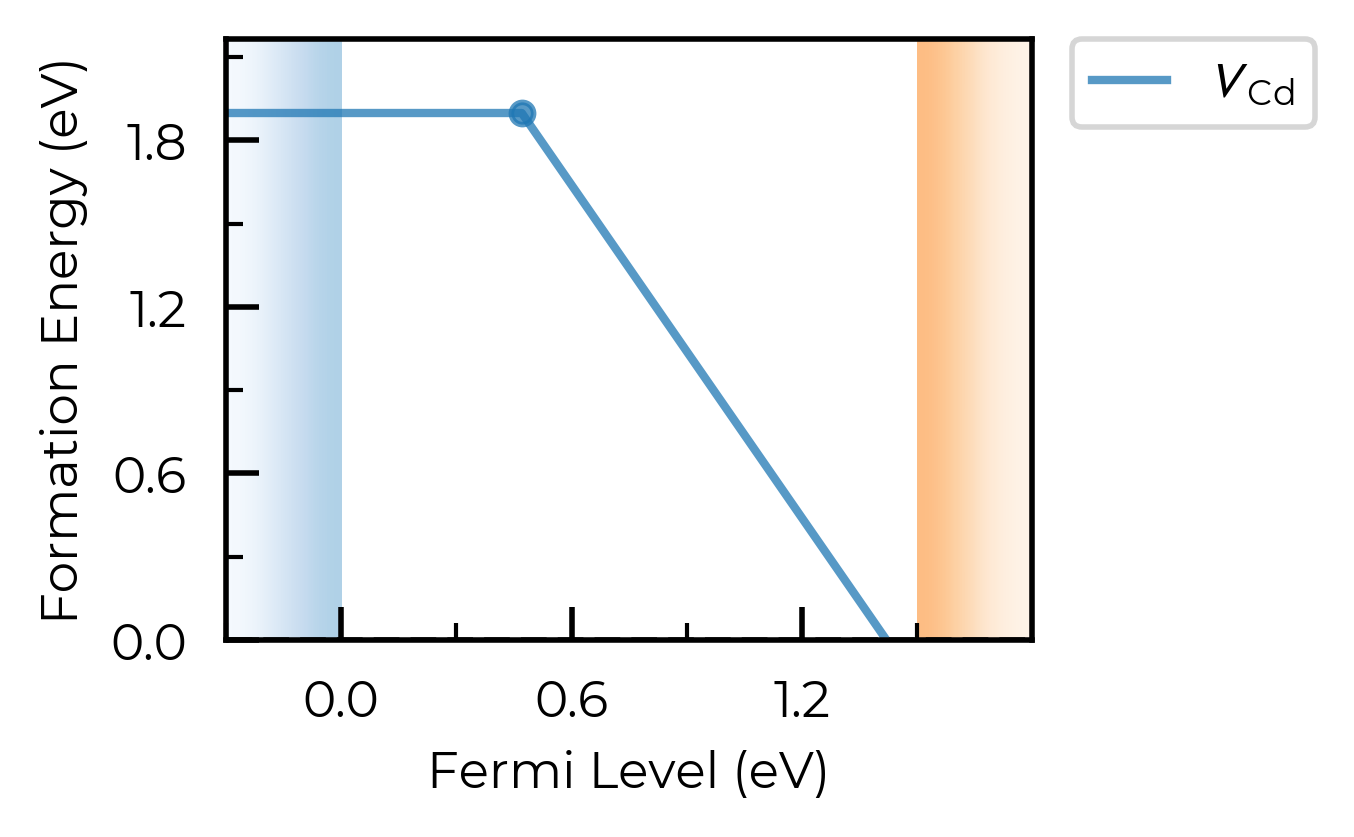

In [37]:
CdTe_example_thermo.plot(limit="Te-rich")  # can set limit to X-rich/poor and doped will automatically determine the most X-rich/poor limit

```{tip}
As shown above, can specify the chemical potential limit at which to obtain and plot the defect formation energies using the ``limit`` parameter, which we can set to either ``"X-rich"/"X-poor"`` where X is an element in the system, in which case the most X-rich/poor limit will be used (e.g. "Cd-rich"), or a key in the ``chempots["limits"]`` dictionary (e.g. ``"Cd-CdTe"`` from that shown above). Alternatively, one can also provide a single chemical potential limit in the form of a dictonary to the ``DefectThermodynamics`` methods – see docstrings for more details.
``` 

There are _many_ options for customising the defect formation energy plots in `doped`, which are illustrated in the `doped` [plotting customisation tutorial](https://doped.readthedocs.io/en/latest/plotting_customisation_tutorial.html).

Here our example dataset has only a few defects included. Let's load a previously-parsed `DefectThermodynamics` object for all intrinsic defects in CdTe:

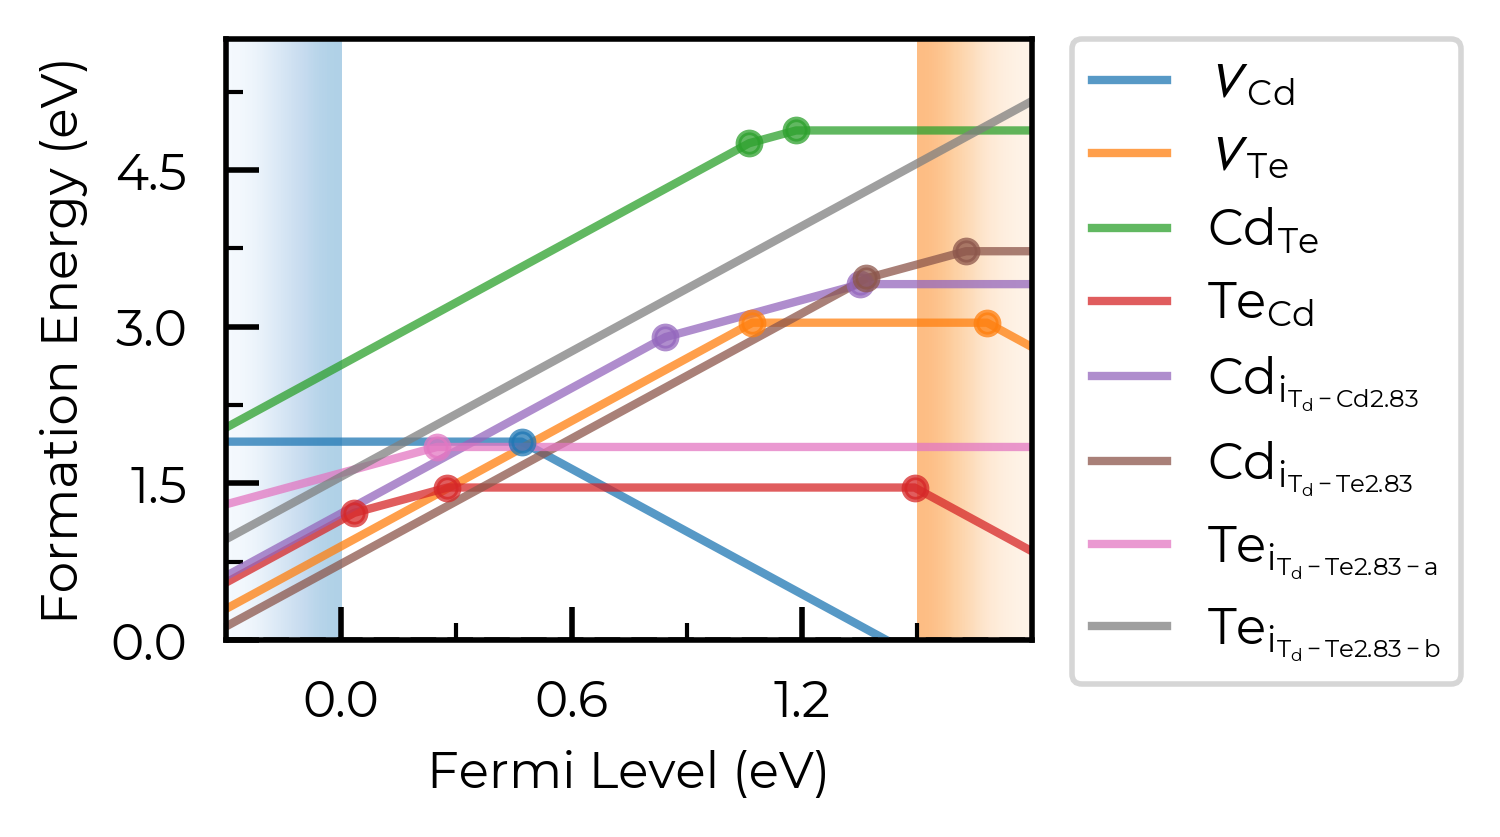

In [38]:
CdTe_defects_thermo = loadfn("CdTe/CdTe_thermo_wout_meta.json.gz")  # excludes metastable states
CdTe_defects_thermo.plot(limit="Te-rich")

Here we can see our different inequivalent sites for the interstitials are automatically labelled
in our plot legend (using the `doped` naming functions), showing that the lowest energy cadmium
interstitial site actually differs between +2 and neutral charge states, as has been noted in this
system in the [literature](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.98.054108).

```{note}
In the above plot, we see `doped` classified Te interstitials into having two separate defect sites. This is dictated by the `dist_tol` parameter in `DefectThermodynamics` (= 1.5 Å by default), which groups together defects which have distances between equivalent defect sites within this tolerance. 
In this case, this is because Te interstitials adopt [split-interstitial dimer structures](https://pubs.rsc.org/en/content/articlelanding/2022/fd/d2fd00043a) for the +1 and neutral charge states, but a different conventional interstitial type structure for the +2 charge state.  
Let's increase it to 1.6 Å here to group these Te interstitials together:
```

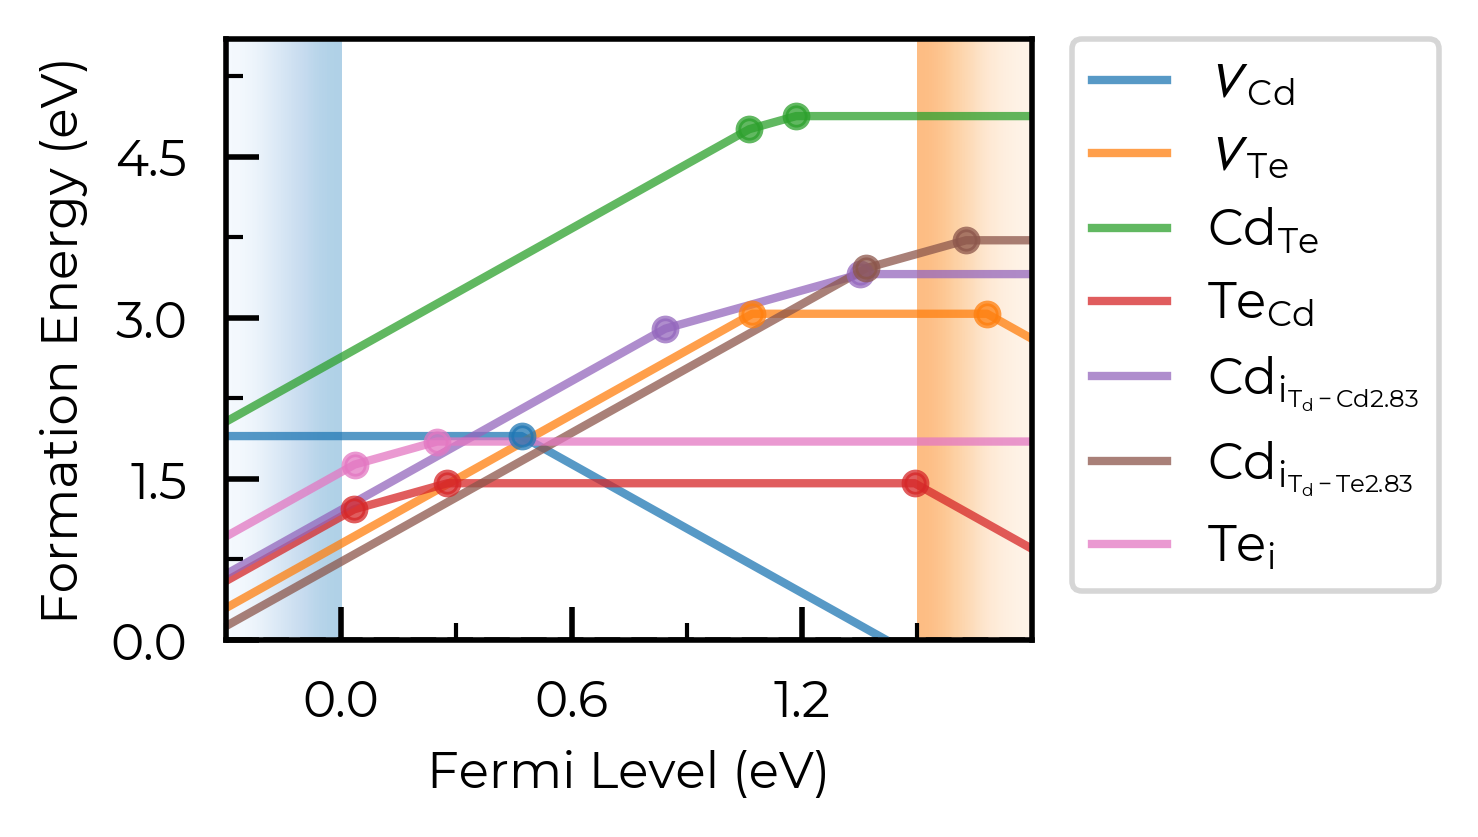

In [39]:
CdTe_defects_thermo.dist_tol = 1.6
CdTe_defects_thermo.plot(limit="Te-rich")

With our `DefectThermodynamics` object, we can tabulate the defect transition levels:

In [40]:
CdTe_defects_thermo.get_transition_levels()

eV from VBM  In Band Gap?
Defect         Charges                            
v_Cd           ε(0/-2)         0.470          True
v_Te           ε(+2/0)         1.071          True
               ε(0/-2)         1.682         False
Cd_Te          ε(+2/+1)        1.062          True
               ε(+1/0)         1.185          True
               ε(0/-1)         1.852         False
               ε(-1/-2)        1.884         False
Te_Cd          ε(+2/+1)        0.034          True
               ε(+1/0)         0.277          True
               ε(0/-2)         1.493          True
Cd_i_Td_Cd2.83 ε(+2/+1)        0.844          True
               ε(+1/0)         1.352          True
Cd_i_Td_Te2.83 ε(+2/+1)        1.367          True
               ε(+1/0)         1.627         False
Te_i_Td_Te2.83 ε(+2/+1)        0.035          True
               ε(+1/0)         0.250          True

We can set `all=True` to show all defect transition levels, including metastable states:

In [41]:
CdTe_defects_thermo.get_transition_levels(all=True)

eV from VBM  In Band Gap?  N(Metastable)
Defect         Charges                                             
v_Cd           ε(0/-1*)          0.543          True              1
               ε(-1*/-2)         0.397          True              1
v_Te           ε(+2/+1*)         1.689         False              1
               ε(+1*/0)          0.453          True              1
               ε(0/-1*)          1.904         False              1
               ε(-1*/-2)         1.460          True              1
Cd_Te          ε(+2/+1)          1.062          True              0
               ε(+1/0)           1.185          True              0
               ε(0/-1)           1.852         False              0
               ε(-1/-2)          1.884         False              0
Te_Cd          ε(+2/+1)          0.034          True              0
               ε(+1/0)           0.277          True              0
               ε(0/-1*)          1.527         False              1
               ε(-1*/-2)         1.460          True              1
Cd_i_Td_Cd2.83 ε(+2/+1)          0.844          True              0
               ε(+1/0)           1.352          True              0
Cd_i_Td_Te2.83 ε(+2/+1)          1.367          True              0
               ε(+1/0)           1.627         False              0
Te_i_Td_Te2.83 ε(+2/+1)          0.035          True              0
               ε(+1/0)           0.250          True              0
               ε(0/-1*)          2.614         False              1
               ε(-1*/-2*)        3.136         False              2

We can print the determined symmetries and degeneracy factors of the defects (automatically incorporated into `doped` concentration calculations – see [Mosquera-Lois et al. _Chem Soc Rev_ 2023](https://pubs.rsc.org/en/content/articlehtml/2023/cs/d3cs00432e) for more details):

In [42]:
CdTe_defects_thermo.get_symmetries_and_degeneracies()

Site_Symm Defect_Symm  g_Orient  g_Spin  g_Total  Mult
Defect         q                                                        
v_Cd           0         Td         C2v       6.0       1      6.0   1.0
               -1        Td         C3v       4.0       2      8.0   1.0
               -2        Td          Td       1.0       1      1.0   1.0
v_Te           +2        Td          Td       1.0       1      1.0   1.0
               +1        Td          Td       1.0       2      2.0   1.0
               0         Td         C2v       6.0       1      6.0   1.0
               -1        Td          Cs      12.0       2     24.0   1.0
               -2        Td          Cs      12.0       1     12.0   1.0
Cd_Te          +2        Td          Td       1.0       1      1.0   1.0
               +1        Td         C2v       6.0       2     12.0   1.0
               0         Td          Cs      12.0       1     12.0   1.0
               -1        Td          Td       1.0       2      2.0   1.0
               -2        Td          C1      24.0       1     24.0   1.0
Te_Cd          +2        Td          Td       1.0       1      1.0   1.0
               +1        Td         C3v       4.0       2      8.0   1.0
               0         Td         C3v       4.0       1      4.0   1.0
               -1        Td          Cs      12.0       2     24.0   1.0
               -2        Td          Cs      12.0       1     12.0   1.0
Cd_i_Td_Cd2.83 +2        Td          Td       1.0       1      1.0   1.0
               +1        Td          Td       1.0       2      2.0   1.0
               0         Td          Td       1.0       1      1.0   1.0
Cd_i_Td_Te2.83 +2        Td          Td       1.0       1      1.0   1.0
               +1        Td          Td       1.0       2      2.0   1.0
               0         Td          Td       1.0       1      1.0   1.0
Te_i_Td_Te2.83 +2        C1          Cs       0.5       1      0.5  24.0
               +1        Cs         C2v       0.5       2      1.0  12.0
               0         C1          C2       0.5       1      0.5  24.0
               -1        C1          C2       0.5       2      1.0  24.0
               -2        C1          C2       0.5       1      0.5  24.0

As shown in further detail in the `doped` [defect thermodynamics tutorial](https://doped.readthedocs.io/en/latest/thermodynamics_tutorial.html), there are many more available methods/functions for the `DefectThermodynamics` object, such as:
- `get_equilibrium_fermi_level`, `get_equilibrium_concentrations` & `get_fermi_level_and_concentrations` (to determine the self-consistent Fermi level and thus defect concentrations for the system, under various thermodynamic conditions)
- `get_doping_windows` & `get_dopability_limits` (to determine the doping windows and limits for the system, under various thermodynamic conditions)
...

### Formation Energy Tables

We can also get tables of the defect formation energies (including terms in the formation energy equation,
such as the charge correction and chemical potentials), as shown below:

In [43]:
formation_energy_df = CdTe_defects_thermo.get_formation_energies(limit="Te-rich")
formation_energy_df

Fermi level was not set, so using mid-gap Fermi level (E_g/2 = 0.75 eV relative to the VBM).


ΔEʳᵃʷ  qE_VBM   qE_F  Σμ_ref  Σμ_formal  E_corr  Eᶠᵒʳᵐ  \
Defect         q                                                             
v_Cd           0    4.166   0.000  0.000  -1.016     -1.251   0.000  1.899   
               -1   6.130  -1.646 -0.749  -1.016     -1.251   0.225  1.692   
               -2   7.661  -3.293 -1.499  -1.016     -1.251   0.738  1.340   
v_Te           +2   1.857   3.293  1.499  -4.471      0.000   0.217  2.395   
               +1   5.410   1.646  0.749  -4.471      0.000  -0.000  3.334   
               0    7.509   0.000  0.000  -4.471      0.000   0.000  3.038   
               -1  10.823  -1.646 -0.749  -4.471      0.000   0.235  4.192   
               -2  13.444  -3.293 -1.499  -4.471      0.000   0.722  4.903   
Cd_Te          +2   1.180   3.293  1.499  -3.455      1.251   0.363  4.130   
               +1   4.223   1.646  0.749  -3.455      1.251   0.029  4.444   
               0    7.083   0.000  0.000  -3.455      1.251   0.000  4.879   
               -1  10.327  -1.646 -0.749  -3.455      1.251   0.253  5.981   
               -2  13.328  -3.293 -1.499  -3.455      1.251   0.783  7.115   
Te_Cd          +2  -5.146   3.293  1.499   3.455     -1.251   0.797  2.646   
               +1  -2.906   1.646  0.749   3.455     -1.251   0.238  1.932   
               0   -0.744   0.000  0.000   3.455     -1.251   0.000  1.459   
               -1   2.271  -1.646 -0.749   3.455     -1.251   0.158  2.237   
               -2   5.008  -3.293 -1.499   3.455     -1.251   0.527  2.947   
Cd_i_Td_Cd2.83 +2  -5.032   3.293  1.499   1.016      1.251   0.683  2.710   
               +1  -2.044   1.646  0.749   1.016      1.251   0.185  2.805   
               0    1.140   0.000  0.000   1.016      1.251   0.000  3.407   
Cd_i_Td_Te2.83 +2  -5.488   3.293  1.499   1.016      1.251   0.656  2.226   
               +1  -2.022   1.646  0.749   1.016      1.251   0.204  2.845   
               0    1.455   0.000  0.000   1.016      1.251   0.000  3.722   
Te_i_Td_Te2.83 +2  -7.105   3.293  1.499   4.471      0.000   0.904  3.062   
               +1  -4.819   1.646  0.749   4.471      0.000   0.300  2.347   
               0   -2.623   0.000  0.000   4.471      0.000   0.000  1.848   
               -1   1.482  -1.646 -0.749   4.471      0.000   0.155  3.712   
               -2   5.887  -3.293 -1.499   4.471      0.000   0.532  6.099   

                                                                Path  \
Defect         q                                                       
v_Cd           0   /Users/kavanase/Library/CloudStorage/OneDrive-...   
               -1  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               -2  /Users/kavanase/Library/CloudStorage/OneDrive-...   
v_Te           +2  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               +1  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               0   /Users/kavanase/Library/CloudStorage/OneDrive-...   
               -1  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               -2  /Users/kavanase/Library/CloudStorage/OneDrive-...   
Cd_Te          +2  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               +1  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               0   /Users/kavanase/Library/CloudStorage/OneDrive-...   
               -1  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               -2  /Users/kavanase/Library/CloudStorage/OneDrive-...   
Te_Cd          +2  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               +1  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               0   /Users/kavanase/Library/CloudStorage/OneDrive-...   
               -1  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               -2  /Users/kavanase/Library/CloudStorage/OneDrive-...   
Cd_i_Td_Cd2.83 +2  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               +1  /Users/kavanase/Library/CloudStorage/OneDrive-...   
               0 

In [44]:
# you can run this cell to see the possible arguments for this function (or go to the python API docs)
CdTe_defects_thermo.get_formation_energies?

```{tip}
The `get_formation_energies` method returns a list of `pandas.DataFrame` objects (or a single
`DataFrame` object if a certain chemical potential `limit` was chosen), which we can save to csv as
shown below. As a `csv` file, this can then be easily imported to `Microsoft Word` or to `LaTeX` (using
e.g.
<a href="https://www.tablesgenerator.com/latex_tables">https://www.tablesgenerator.com/latex_tables</a>)
 to be included in Supporting Information of papers or
 in theses, which we would recommend for open-science, queryability and reproducibility!
```

In [45]:
formation_energy_df.to_csv(f"CdTe_Formation_Energies_Te_Rich.csv", index=False)

In [46]:
!head CdTe_Formation_Energies_Te_Rich.csv

ΔEʳᵃʷ,qE_VBM,qE_F,Σμ_ref,Σμ_formal,E_corr,Eᶠᵒʳᵐ,Path,Δ[E_corr]
4.166,0.0,0.0,-1.016,-1.251,0.0,1.899,/Users/kavanase/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/CdTe/VASP_Files/vac_1_Cd_0/vasp_ncl,0.0
6.13,-1.646,-0.749,-1.016,-1.251,0.225,1.692,/Users/kavanase/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/CdTe/VASP_Files/vac_1_Cd_-1/vasp_ncl,0.008
7.661,-3.293,-1.499,-1.016,-1.251,0.738,1.34,/Users/kavanase/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/CdTe/VASP_Files/vac_1_Cd_-2/vasp_ncl,0.011
1.857,3.293,1.499,-4.471,0.0,0.217,2.395,/Users/kavanase/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/CdTe/VASP_Files/vac_2_Te_2/vasp_ncl,0.021
5.41,1.646,0.749,-4.471,0.0,-0.0,3.334,/Users/kavanase/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/CdTe/VASP_Files/vac_2_Te_1/vasp_ncl,0.004
7.509,0.0,0.0,-4.471,0.0,0.0,3.038,/Users/kavanase/Library/CloudStorage/OneDrive-ImperialCollegeLondon/B

Example LaTeX table generated from the above csv file for a thesis:

![image.png](../examples/CdTe/CdTe_LaTeX_get_formation_energies_example.png)

<a id='charge_corrections'></a>
## Analysing Finite-Size Charge Corrections
### Kumagai-Oba (eFNV) Charge Correction Example:

As mentioned above, `doped` can automatically compute either the Kumagai-Oba (eFNV) or Freysoldt (FNV) 
finite-size charge corrections, to account for the spurious image charge interactions in the defect 
supercell approach (see the
[YouTube](https://youtu.be/FWz7nm9qoNg)/[B站](https://www.bilibili.com/list/6073855/?sid=4603908&oid=113988666990435&bvid=BV1V5KVeYEMn)
defects tutorial for more details).
The eFNV correction is used by default if possible (if the required `OUTCAR(.gz)` files are available), 
as it is more general – can be used for both isotropic and
 anisotropic systems – and the numerical implementation is more efficient, requiring smaller file sizes 
 and running quicker.

Below, we show some examples of directly visualising the charge correction plots (showing how they are 
computed), which is recommended if any warnings about the charge correction accuracy are printed when 
parsing our defects (also useful for understanding how the corrections are performed!).

Here we're taking the example of a 
Fluorine-on-Oxygen antisite substitution defect in 
Y<sub>2</sub>Ti<sub>2</sub>O<sub>5</sub>S<sub>2</sub> (a potential photocatalyst and _n_-type thermoelectric), which has a non-cubic anisotropic structure and
 dielectric constant:

In [47]:
from doped.analysis import DefectParser  # can use DefectParser to parse individual defects if desired
F_O_1_entry = DefectParser.from_paths(defect_path="YTOS/F_O_1", bulk_path="YTOS/Bulk",
                                                dielectric = [40.7, 40.7, 25.2]).defect_entry
print(f"Charge: {F_O_1_entry.charge_state:+} at site: {F_O_1_entry.defect_supercell_site.frac_coords}")
print(f"Finite-size charge corrections: {F_O_1_entry.corrections}")

Charge: +1 at site: [0. 0. 0.]
Finite-size charge corrections: {'kumagai_charge_correction': 0.12691248591191379}


Above, the defect has been parsed and the anisotropic (eFNV) charge correction correctly applied, with no warnings thrown. We can directly plot the atomic site potentials which are used to compute this charge correction if we want:
(Though typically we only do this if there has been some warning or error related to the application of the defect charge correction – here we're just showing as a demonstration)

```{note}
Typically we only analyze the charge correction plots like this if there has been some warning
 or error related to the defect charge correction (or to aid our understanding of the underlying 
formation energy calculations). Here we're just showing as a demonstration.
```

Calculated Kumagai (eFNV) correction is 0.127 eV


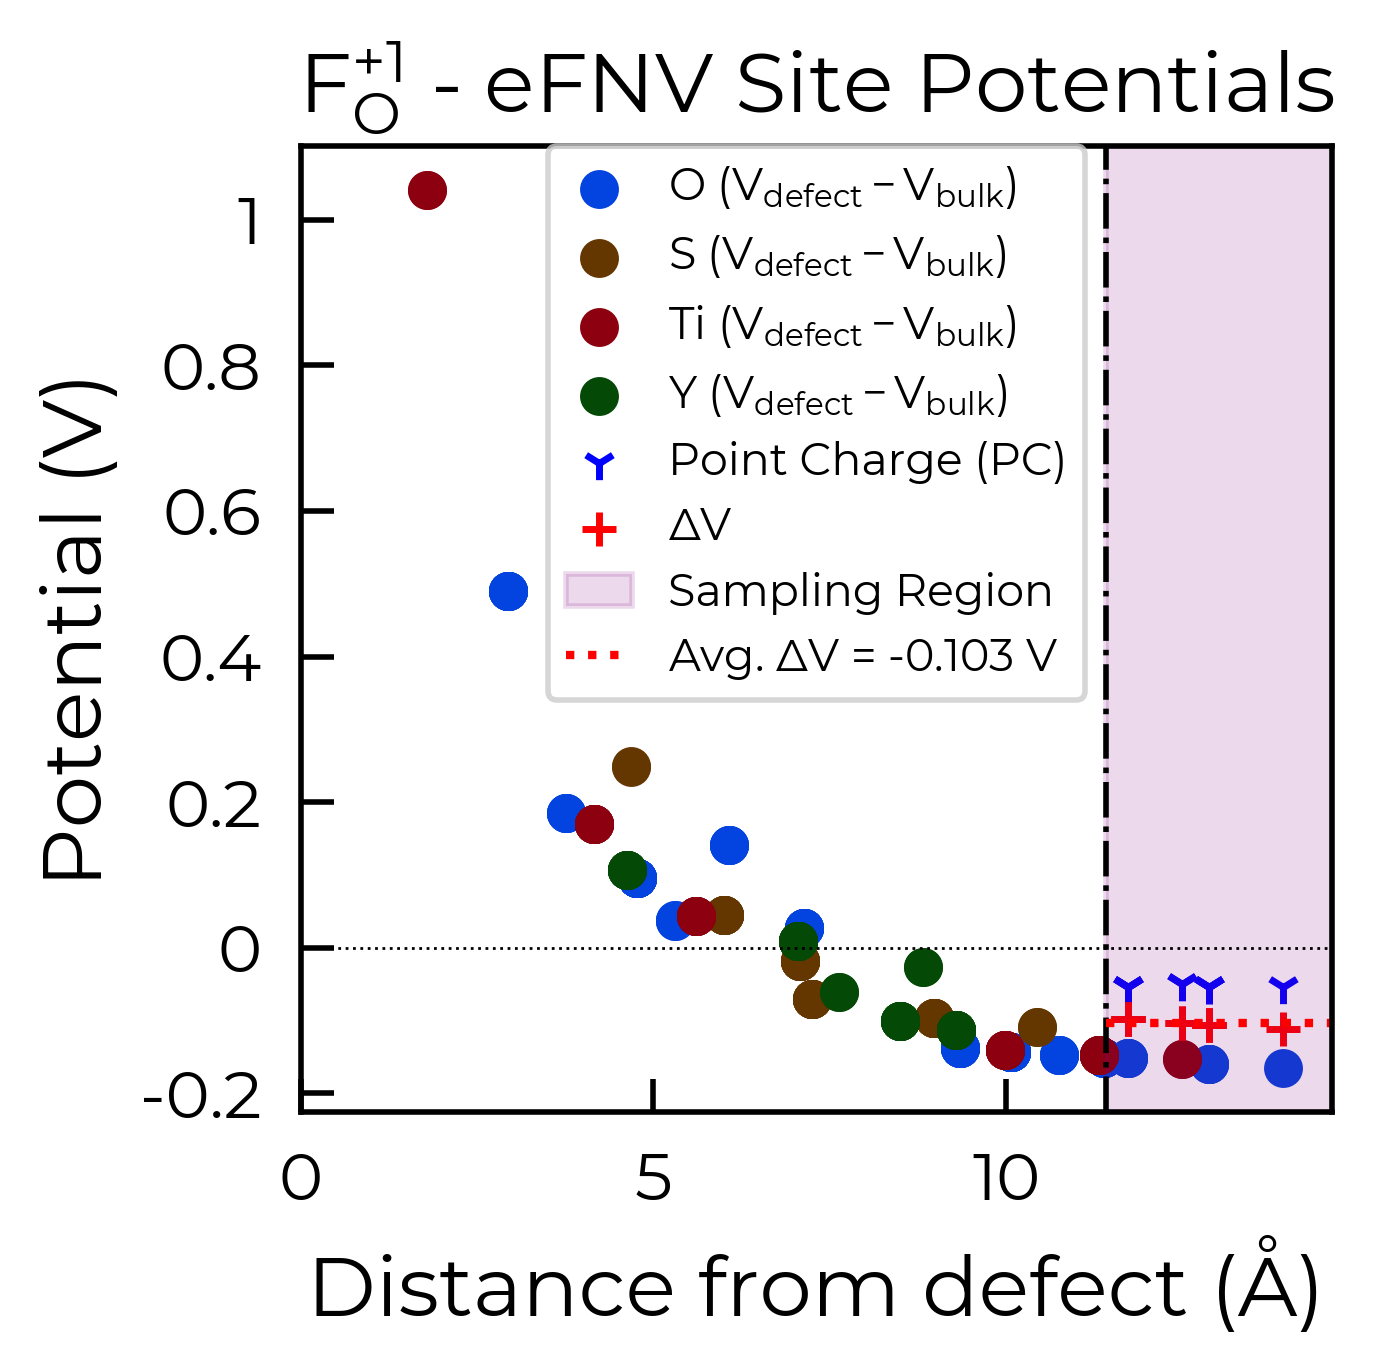

In [48]:
correction, plot = F_O_1_entry.get_kumagai_correction(plot=True)
plot

Here we can see we obtain a good plateau in the atomic potential differences (ΔV) between the 
defect and bulk supercells in the 'sampling region' (i.e. region of defect supercell furthest from the 
defect site), the average of which is used to obtain our potential alignment ('Avg. ΔV') and 
thus our final charge correction term.

If there is still significant variance in the site potential differences in the sampling region (i.e. a 
converged plateau is not obtained), then this suggests that the charge correction may not be as accurate
 for that particular defect or supercell. This error range of the charge correction is automatically 
 computed by `doped` (by multiplying the defect charge with the standard error of the mean of the electrostatic potential differences in the sampling region), and can be returned using the `return_correction_error` argument in 
 `get_kumagai_correction`/`get_freysoldt_correction`, or also by adjusting the `error_tolerance` argument: 

In [49]:
correction = F_O_1_entry.get_kumagai_correction(error_tolerance=0.0001)  # extremely strict tolerance, 0.1 meV

Calculated Kumagai (eFNV) correction is 0.127 eV


core.py:262: UserWarning: Estimated error in the Kumagai (eFNV) charge correction for defect F_O_1 is 1.33e-03 eV (i.e. which is greater than the `error_tolerance`: 1.00e-04 eV). You may want to check the accuracy of the correction by plotting the site potential differences (using `defect_entry.get_kumagai_correction()` with `plot=True`). Large errors are often due to unstable or shallow defect charge states (which can't be accurately modelled with the supercell approach; see https://doped.readthedocs.io/en/latest/Tips.html#perturbed-host-states). If this error is not acceptable, you may need to use a larger supercell for more accurate energies.


In [50]:
correction, error = F_O_1_entry.get_kumagai_correction(return_correction_error=True)
error  # calculated error range of 1.3 meV in our charge correction here

Calculated Kumagai (eFNV) correction is 0.127 eV


0.001327647647127421

### Freysoldt (FNV) Charge Correction Example:

Above, we used the Kumagai-Oba (eFNV) defect image charge correction scheme, which is compatible only 
with both isotropic and anisotropic dielectric screening. 

`doped` also supports the original Freysoldt 
(FNV) charge correction scheme, however this should only be used for _isotropic/cubic host materials_ (and even then 
the eFNV correction is still preferred, being more efficient and robust in implementation). For the FNV 
correction, the `LOCPOT(.gz)` output files must be present in our defect and bulk supercell 
calculation directories.

Calculated Freysoldt (FNV) correction is 0.739 eV


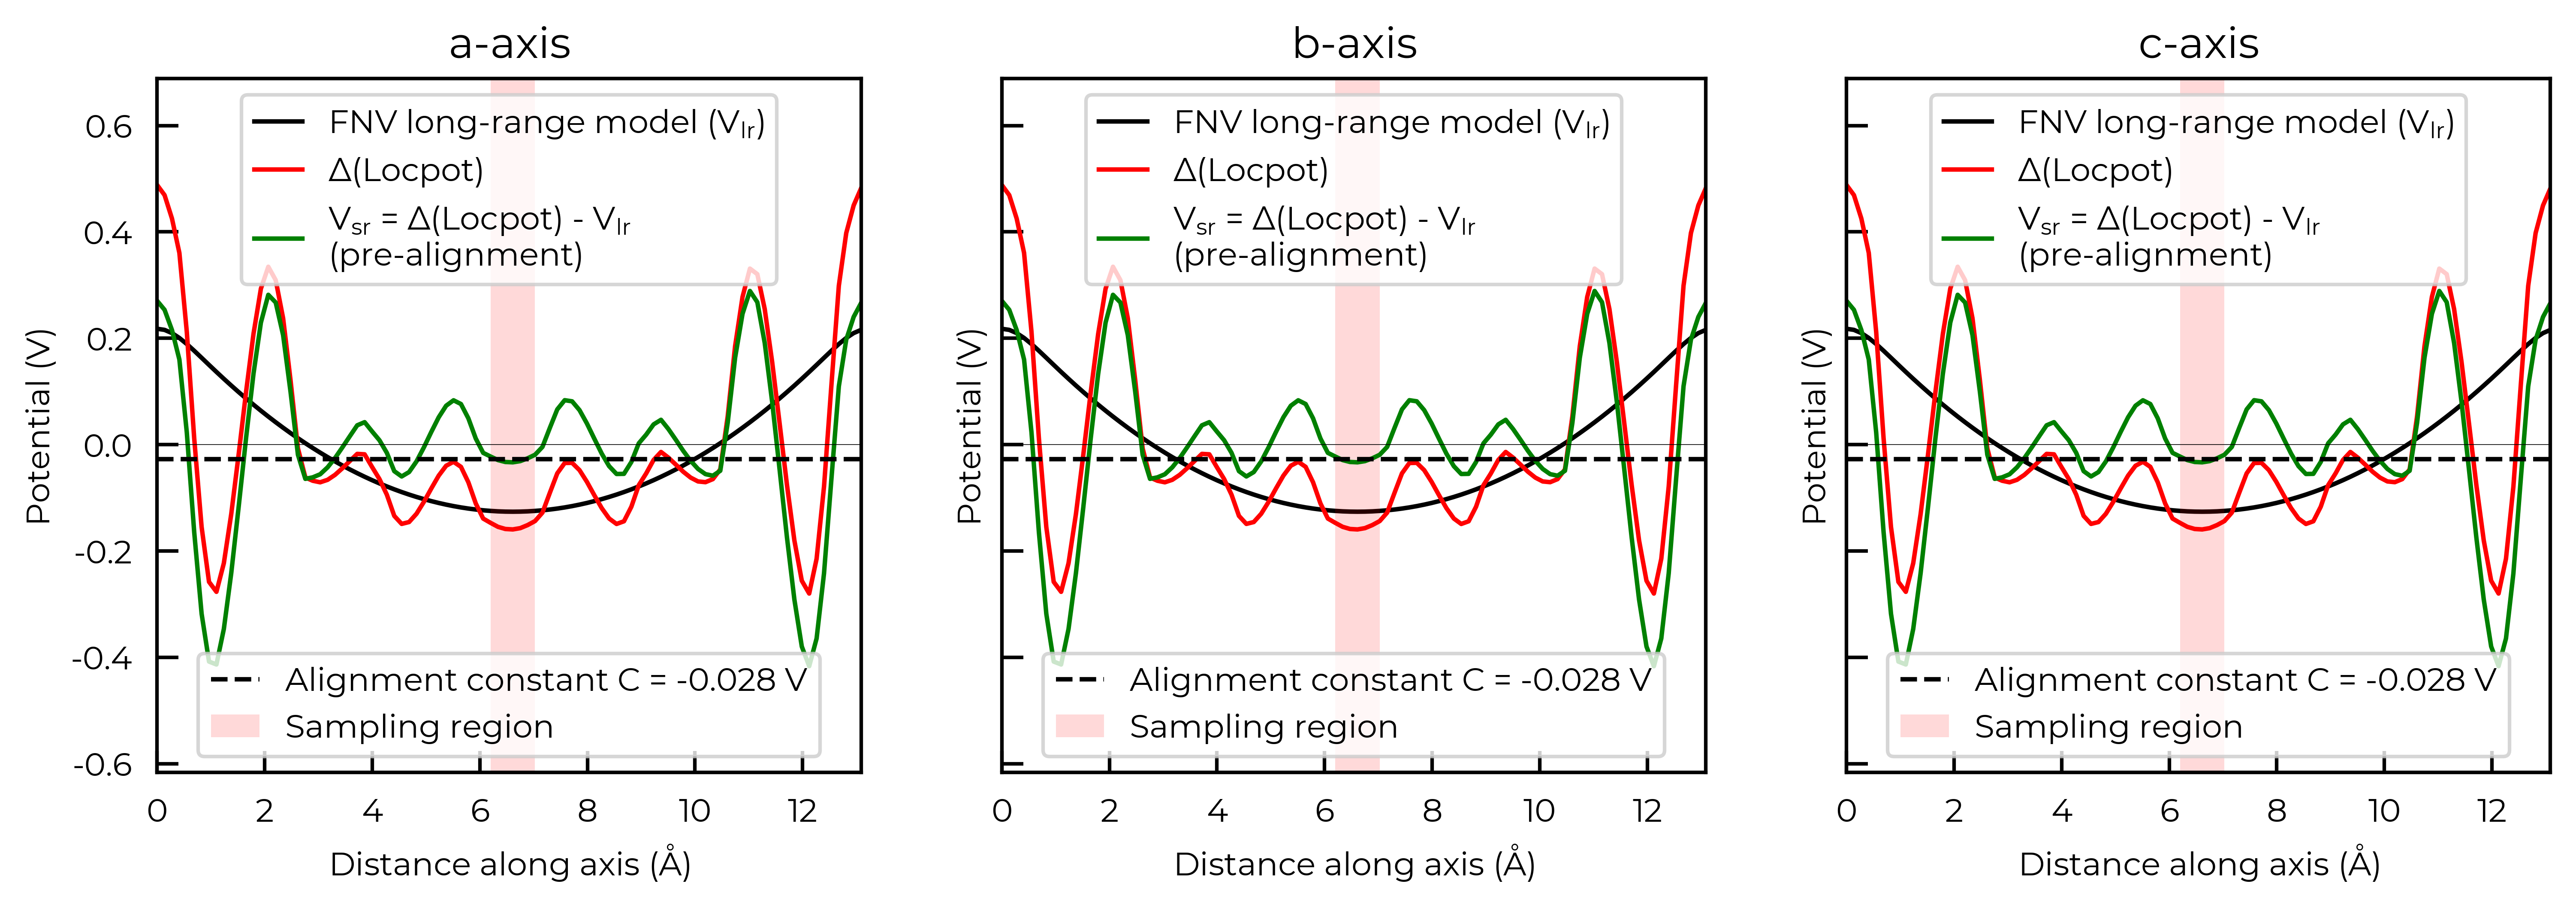

In [52]:
correction, plot = dp.defect_dict["v_Cd_-2"].get_freysoldt_correction(plot=True)
plot

## Further Defect Analysis

As briefly discussed in the
[YouTube](https://youtu.be/FWz7nm9qoNg)/[B站](https://www.bilibili.com/list/6073855/?sid=4603908&oid=113988666990435&bvid=BV1V5KVeYEMn)
defects tutorial, you will likely
want to further analyse the key defect species in your material, by e.g. visualising the relaxed
structures with `VESTA`/`CrystalMaker`, looking at the defect single-particle energy levels using the
[sumo](https://smtg-bham.github.io/sumo/) DOS plotting functions (`sumo-dosplot`), charge density
distributions (e.g. this [Figure](https://doi.org/10.1021/acsenergylett.1c00380#fig2)).

In particular, you will likely want to analyse the thermodynamic (i.e. concentrations) and electronic (i.e. doping) behaviour of defects in your system, which is demonstrated in the `doped` [thermodynamics tutorial](https://doped.readthedocs.io/en/latest/thermodynamics_tutorial.html). Some other analyses that you can perform using your parsed `doped` `DefectEntry` objects is also shown in the [advanced analysis tutorial](https://doped.readthedocs.io/en/latest/advanced_analysis_tutorial.html).

Beyond this, you may want to further analyse the behaviour and impact on material properties of your
defects using advanced defect analysis codes such as [py-sc-fermi](https://py-sc-fermi.readthedocs.io/en/latest/) (to analyse defect concentrations, doping and Fermi level tuning under more complex thermodynamic constraints), [easyunfold](https://smtg-bham.github.io/easyunfold/) (to analyse the electronic structure of defects in your
material), or [nonrad](https://nonrad.readthedocs.io/en/latest/) / [CarrierCapture.jl](https://wmd-group.github.io/CarrierCapture.jl/dev/) (to analyse non-radiative electron-hole recombination at defects).
The outputs from `doped` are readily ported as inputs to these codes.